In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style="darkgrid")
import os
import sys
import matplotlib.pyplot as plt
from scipy import stats
from scipy import spatial
from scipy.signal import savgol_filter,argrelextrema
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

## Variables

In [3]:
lightname = "light"
lightunit = "ppfd"
timename = "time[s]"
hourname = "time[h]"
odtype = "680" # which OD to use
odname = "OD("+odtype+"nm)"
filetype = '.csv'
lightcons = 8 #number of different light conditions used

cols = [timename,250,500,750,1000,1250,1500,1750,2000,"replicate"]
colnames = []
for i in range(len(cols)):
    if i == 0 or i==len(cols)-1:
        colnames.append(cols[i])
        continue
    col = odname+str(cols[i])
    colnames.append(col)
print(colnames)

['time[s]', 'OD(680nm)250', 'OD(680nm)500', 'OD(680nm)750', 'OD(680nm)1000', 'OD(680nm)1250', 'OD(680nm)1500', 'OD(680nm)1750', 'OD(680nm)2000', 'replicate']


## Functions

In [ ]:
def smooth(y,x):
    yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3

## Cleaning Data

In [35]:
path = os.getcwd()
filenames = os.listdir() # run on all <filetype> files
# filenames = ['A4_A_09302020.csv','A4_B_10012020.csv','A4_C_10022020.csv'] #choose files to run on
replicates = [] #file that contains all replicates of an experiment
# light_dict = {} #format:: {250:[replicate1,rep2,rep3], 500:[replicate1,rep2,rep3]}
replicates_wide = [] #same as replicates but in wide format
runstart = [177,0,237] # row number where the experiment starts (found using excel)
i = 0
for name in (filenames):
    if filetype not in name:
        continue
    filepath = os.path.join(path,name)
    print("Processing:: "+name)
    
    #clean up csv
    A = pd.read_csv(name,skiprows=4,index_col=False)
    cols = [col for col in A.columns
            if odtype not in col and timename not in col]
#     print(cols) # column names to remove
    A = A.drop(columns=cols)
    A = A.drop(index = list(range(0,runstart[i]-1))) # trimming each replicate to the start of the run
#     print(A.head())
    repname = [i] * len(A)
    A["replicate"] = repname # numbering each replicate for later analysis
#     print(A.columns,'\n',colnames)
    A.columns = colnames
    
    #removing duplicate times in each
    len0 = len(A)
    A = A.drop_duplicates(subset=[timename])
    len1 = len(A)
    diff = len0 - len1
    if diff != 0:
        print(name+":: Dropped",diff,"rows with duplicate \""+timename+"\" values")
    
    # changing from seconds to hours and resetting experiment start time to 0
    s_to_h = 300 / 3600 # 300 seconds between readings / seconds in hour
    t_series = np.arange(0,len(A),1)*s_to_h
    A[timename] = t_series
    A = A.rename(columns={timename:hourname}) #change column name to hours
    
    #storing each replicate in wide format for later averaging and smoothing
    replicates_wide.append(A)
#     print(A)
    
    # changing data format to long for plotting
    A = pd.wide_to_long(A, odname, i=hourname, j=lightname)
    replicates.append(A)
    i+=1
    
replen = len(replicates)
df = pd.concat(replicates)
df.reset_index(inplace=True)

# adding ppfd because seaborn will ROUND if we just have an integer
df[lightname] = df[lightname].apply(lambda x: str(x) +" "+ lightunit)
df

Processing:: A4_A_09302020.csv
Processing:: A4_B_10012020.csv
Processing:: A4_C_10022020.csv


,time[h],light,replicate,OD(680nm)
0,0.000000,250 ppfd,0,0.104
1,0.083333,250 ppfd,0,0.107
2,0.166667,250 ppfd,0,0.108
3,0.250000,250 ppfd,0,0.110
4,0.333333,250 ppfd,0,0.114
...,...,...,...,...
6803,20.916667,2000 ppfd,2,2.775
6804,21.000000,2000 ppfd,2,2.775
6805,21.083333,2000 ppfd,2,2.696
6806,21.166667,2000 ppfd,2,2.775


## Curve Averaging and Smoothing

#### Averaging replicates

In [79]:
#shortening the curves to the minimum length curve
replength = 0 #minimum length curve
for rep in replicates_wide:
    length = len(rep)
    if replength == 0:
        replength = length
    elif replength > length:
        replength = length
reps = []
for rep in replicates_wide:
    short_rep = rep.iloc[:replength].reset_index(drop=True) #shorten and reset index
#     print(short_rep.tail())
    reps.append(short_rep)
    
# finding average and standard deviation at each time point and each light value
mean_od_df = pd.concat(reps).groupby(level=0).mean().drop(columns="replicate")
std_od_df = pd.concat(reps).groupby(level=0).std().drop(columns="replicate")
std_od_df[hourname] = mean_od_df[hourname]
mean_od_df

,time[h],OD(680nm)250,OD(680nm)500,OD(680nm)750,OD(680nm)1000,OD(680nm)1250,OD(680nm)1500,OD(680nm)1750,OD(680nm)2000
0,0.000000,0.109667,0.117000,0.120333,0.132000,0.129667,0.129000,0.108333,0.108000
1,0.083333,0.111333,0.120667,0.122000,0.134667,0.131000,0.129000,0.115000,0.108333
2,0.166667,0.113000,0.122000,0.123000,0.137667,0.133667,0.134000,0.116667,0.111333
3,0.250000,0.114000,0.122667,0.124667,0.141333,0.134333,0.133667,0.116000,0.112667
4,0.333333,0.114000,0.123000,0.127000,0.137667,0.134333,0.133000,0.117333,0.111333
...,...,...,...,...,...,...,...,...,...
218,18.166667,0.758333,1.829667,2.117667,2.141000,2.278333,2.254333,2.159000,2.114667
219,18.250000,0.762667,1.841667,2.117667,2.159667,2.284000,2.266333,2.159000,2.135333
220,18.333333,0.771000,1.847333,2.133000,2.179667,2.284000,2.278667,2.163333,2.136333
221,18.416667,0.777000,1.858000,2.138667,2.184667,2.277333,2.286667,2.186667,2.143333


#### Smoothing Curves

In [86]:
smooth = mean_od_df.copy(deep=True)
for (columnName, columnData) in smooth.iteritems():
    if columnName == hourname:
        continue
    smooth[columnName] = savgol_filter(columnData.values, 101, 2) # data array, window size, polynomial order
# smooth

#### Changing from wide to long format for plotting

In [87]:
smooth_wide = smooth.copy(deep=True)
smooth = pd.wide_to_long(smooth, odname, i=hourname, j=lightname)
smooth.reset_index(inplace=True)

# adding ppfd because seaborn will ROUND if we just have an integer
smooth[lightname] = smooth[lightname].apply(lambda x: str(x) +" "+ lightunit)
smooth

,time[h],light,OD(680nm)
0,0.000000,250 ppfd,0.112861
1,0.083333,250 ppfd,0.113408
2,0.166667,250 ppfd,0.113972
3,0.250000,250 ppfd,0.114553
4,0.333333,250 ppfd,0.115152
...,...,...,...
1779,18.166667,2000 ppfd,2.100897
1780,18.250000,2000 ppfd,2.106408
1781,18.333333,2000 ppfd,2.111765
1782,18.416667,2000 ppfd,2.116971


## Initial Plots

In [88]:
# title = 'Smoothed Average OD'
# plt.figure(figsize=(8,5), dpi=150)
# palette = sns.color_palette("rainbow_r", lightcons)
# g = sns.lineplot(x=hourname, y=odname,
#              hue=lightname,
#              palette=palette,data=smooth).set_title(title)

## Finding Max Growth Rate

In [103]:
#adapted minorly from https://github.com/Bahler-Lab/pyphe/blob/2de4c40bba4cb614e77cb4f503ec4f699144ef1e/pyphe/growthcurves.py#L50
def find_max_slope(x,t,fitrange, find_min_instead=False):
    '''Find max_slope, t_max, intercept and r2 for a single growthcurve. The regression is aware of the timepoints so this will work with unevenly samples growthcurves.
    Required arguments:
    x (array-like) -- 1D array-like containing the population/colony sizes
    t (array-like) -- 1D array-like containing the timepoints, must have same dimensions as x
    reg_fitrange (int) -- The number of timepoints over which to fit the linear regression
    Returns:
    {
    max_slope -- The slope of the regression
    t_max -- The mid-point of the fitrange of the regression
    intercept -- The y-inyercept of the regression
    r2 -- The R^2 value of the regression
    }
    '''
    regression_results = []

    for i in range(len(x)-fitrange):
        slope, intercept, r_value, p_value, std_err = stats.linregress(t[i:i+fitrange], x[i:i+fitrange])
        regression_results.append({'t_max':np.mean(t[i:i+fitrange]), 'max_slope':slope, 'r2':r_value**2, 'y-intercept':intercept})

    if find_min_instead:
        slope_result = pd.Series(min(regression_results, key=lambda x: x['max_slope']))
    else:
        slope_result = pd.Series(max(regression_results, key=lambda x: x['max_slope']))

    slope_result['x-intercept'] = -slope_result['y-intercept']/slope_result['max_slope']
    return slope_result

In [114]:
one_curve = smooth_wide["OD(680nm)750"].values
timepoints = smooth_wide[hourname].values
find_max_slope(one_curve,timepoints,5)

t_max          12.916667
max_slope       0.203801
r2              0.999999
y-intercept    -1.331617
x-intercept     6.533922
dtype: float64

## Plots without averaging

Text(0.5, 1.0, 'Holistic Replicate Comparison')

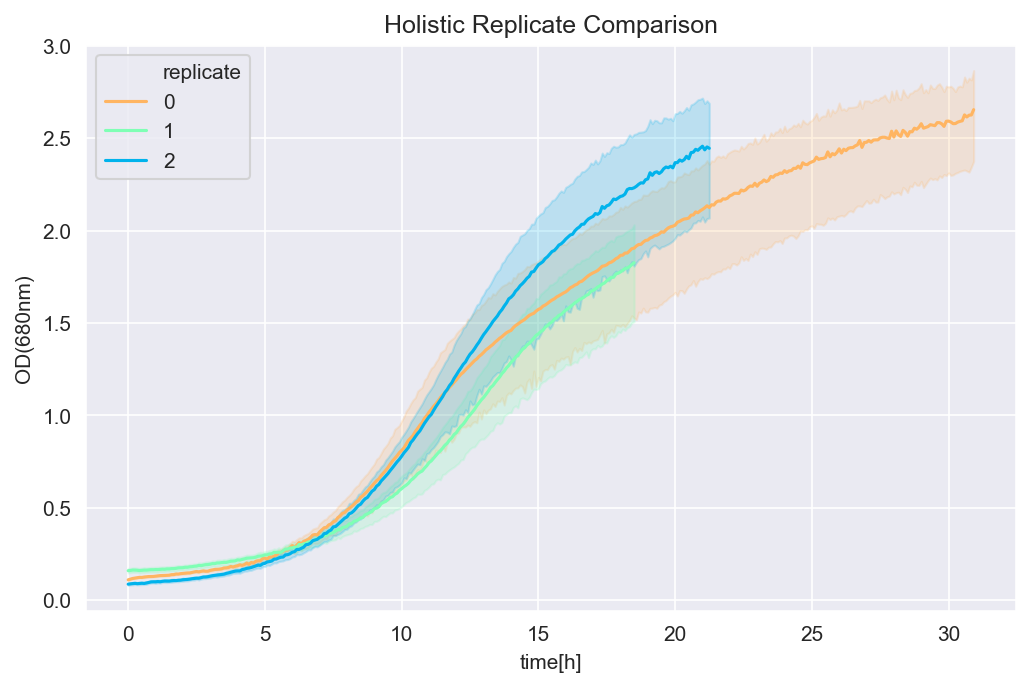

In [54]:
title = 'Holistic Replicate Comparison'
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", replen)
sns.lineplot(x=hourname, y=odname,hue="replicate",palette=palette,data=df).set_title(title)

In [50]:
# title = 'All Curves Plotted'
# plt.figure(figsize=(8,5), dpi=150)
# palette = sns.color_palette("rainbow_r", lightcons)
# g = sns.lineplot(x=hourname, y=odname,
#              hue=lightname, style="replicate",
#              palette=palette,data=df).set_title(title)

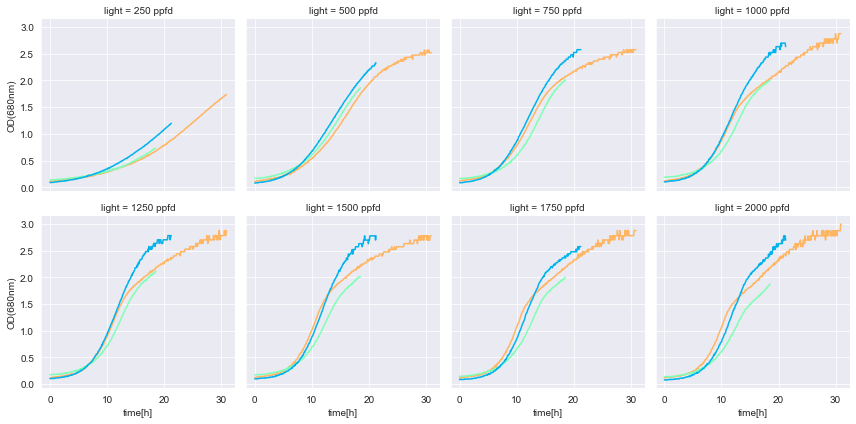

In [53]:
title = "Replicate Comparison"
# g = plt.figure(figsize=(12,8), dpi=300)
palette = sns.color_palette("rainbow_r", replen)
g = sns.FacetGrid(df, col=lightname, hue="replicate",col_wrap=4,palette=palette)
g.map(sns.lineplot, hourname, odname)

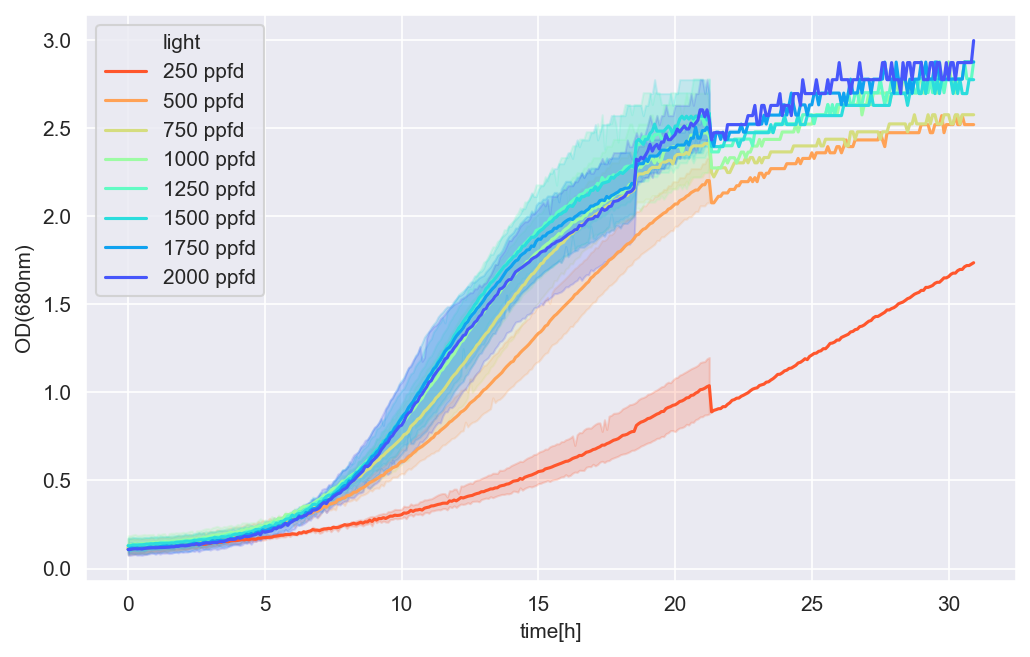

In [10]:
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", lightcons)
sns.lineplot(x=hourname, y=odname,hue=lightname,palette=palette,data=df)